# Import Packages

In [9]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

In [10]:
import tensorflow as tf
import os
import json
import pandas as pd
import re
import numpy as np
import time
import matplotlib.pyplot as plt
import collections
import random
import requests
import json
from math import sqrt
from PIL import Image
from tqdm.auto import tqdm
from wordcloud import WordCloud 

# Read the COCO dataset

In [11]:
BASE_PATH = 'F:\\Ml files\\COCO dataset Image captioning\\Coco Dataset'

# Read training dataset 

In [12]:

with open(f'{BASE_PATH}/annotations/captions_train2017.json', 'r') as f:
    data = json.load(f)
    data = data['annotations']

img_cap_pairs = []

for sample in data:
    img_name = '%012d.jpg' % sample['image_id']
    img_cap_pairs.append([img_name, sample['caption']])

train_data = pd.DataFrame(img_cap_pairs, columns=['image', 'caption'])
train_data['image'] = train_data['image'].apply(
    lambda x: f'{x}'
)
train_data = train_data.reset_index(drop=True)
train_data.head()

,image,caption
0,000000203564.jpg,A bicycle replica with a clock as the front wh...
1,000000322141.jpg,A room with blue walls and a white sink and door.
2,000000016977.jpg,A car that seems to be parked illegally behind...
3,000000106140.jpg,A large passenger airplane flying through the ...
4,000000106140.jpg,There is a GOL plane taking off in a partly cl...


# Reading the test data

In [13]:
with open(f'{BASE_PATH}/annotations/captions_val2017.json', 'r') as f:
    test_data = json.load(f)
    test_data = test_data['annotations']

test_img_cap_pairs = []

for test_sample in test_data:
    test_img_name = '%012d.jpg' % test_sample['image_id']
    test_img_cap_pairs.append([test_img_name, test_sample['caption']])

test_data = pd.DataFrame(test_img_cap_pairs, columns=['image', 'caption'])
test_data['image'] = test_data['image'].apply(
    lambda x: f'{x}'
)

test_data = test_data.reset_index(drop=True)
test_data.head()

,image,caption
0,000000179765.jpg,A black Honda motorcycle parked in front of a ...
1,000000179765.jpg,A Honda motorcycle parked in a grass driveway
2,000000190236.jpg,An office cubicle with four different types of...
3,000000331352.jpg,A small closed toilet in a cramped space.
4,000000517069.jpg,Two women waiting at a bench next to a street.


# Creation of validation data

In [14]:
def sample_first_prows(data, perc=0.9):
    return data.head(int(len(data)*(perc)))

train = sample_first_prows(train_data)
validation = train_data.iloc[max(train.index):]

In [15]:
train.to_csv('F:\\Ml files\\COCO dataset Image captioning\\data\\train.csv',index=False)
validation.to_csv('F:\\Ml files\\COCO dataset Image captioning\\data\\validation.csv',index=False)
test_data.to_csv('F:\\Ml files\\COCO dataset Image captioning\\data\\test.csv',index=False)

# Exploratory Data Analysis

## Random sample of image and its caption

In [16]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    
    return img

def display_images(temp_df, imgPath):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1   
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"{imgPath}{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

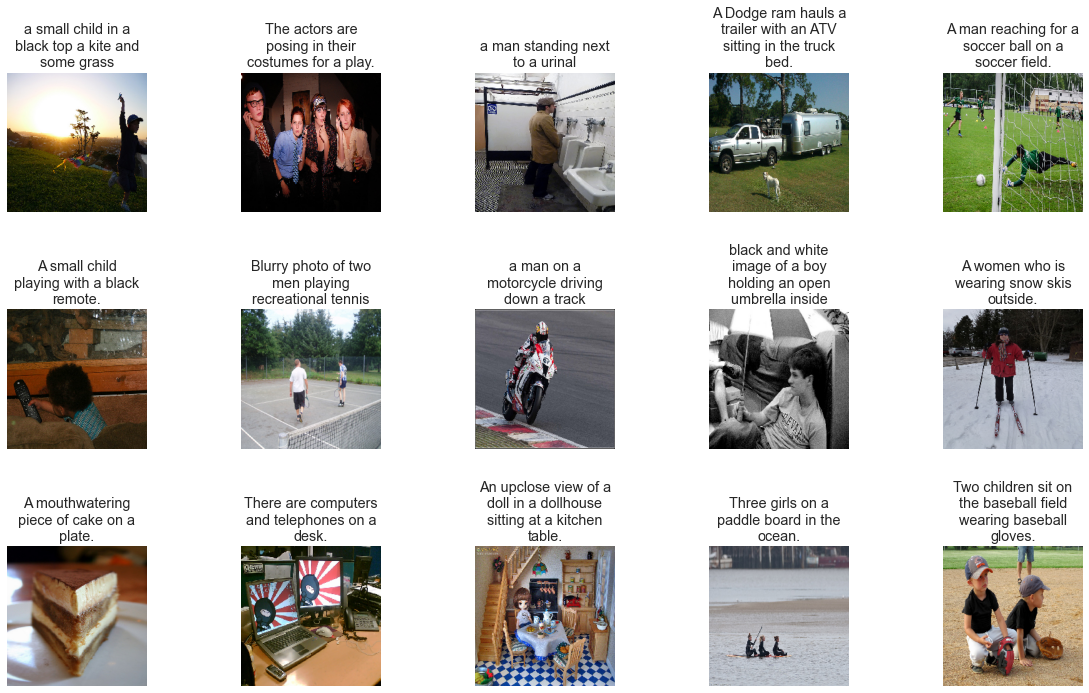

In [18]:
display_images(train_data.sample(15), "F:\\Ml files\\COCO dataset Image captioning\\Coco Dataset/train2017/")

## Wordcloud of captions 

(-0.5, 1439.5, 1079.5, -0.5)

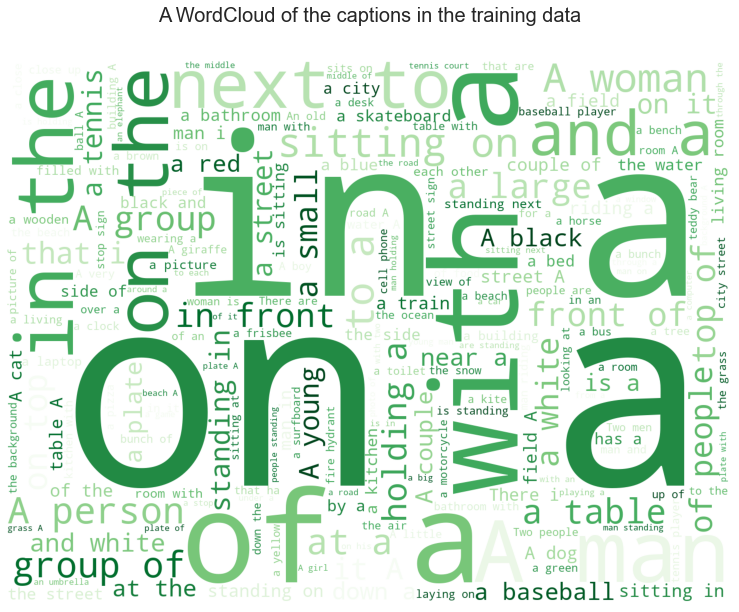

In [19]:
cloud = WordCloud(width=1440, height=1080,stopwords={'nan'},colormap='Greens',background_color='white').generate(" ".join(train_data['caption'].astype(str)))
plt.figure(figsize=(16, 10))
plt.title('A WordCloud of the captions in the training data',fontsize=20,pad=40)
plt.imshow(cloud)
plt.axis('off')

## Data destribution

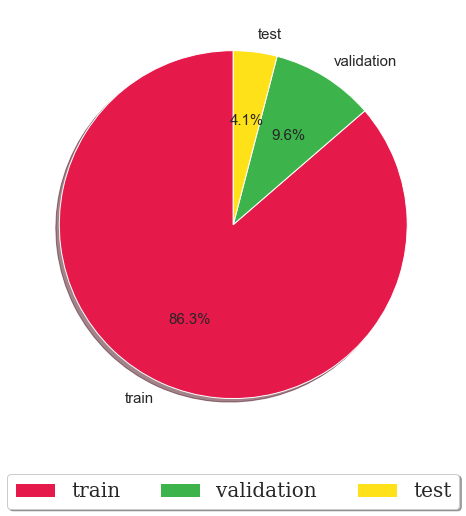

In [20]:
total=[train.shape[0],validation.shape[0],test_data.shape[0]]
names = ["train", "validation", "test"]
sns.set_style('whitegrid')
plt.figure(figsize=(10,8))
plt.pie(total,labels=names,startangle=90,colors=['#e6194b', '#3cb44b', '#ffe119'], 
        autopct='%1.1f%%',explode = (0,0,0),shadow=True,textprops={'fontsize': 15})
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),prop={'size': 20},
          fancybox=True, shadow=True, ncol=3)
plt.show()